In [350]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [351]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')


In [352]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')


In [353]:
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
pp.ProfileReport(train_df, title = 'Pandas Profiling report of "Train" set', html = {'style':{'full_width': True}})

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [354]:
#dropping unnecessary columns
train_df = train_df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1)

In [355]:
test_df = test_df.drop(['Name', 'Cabin', 'Ticket'], axis = 1)

In [356]:
data = [train_df, test_df]
for dataset in data:
    mean = dataset['Age'].mean()
    dataset['Age'].fillna(mean, inplace = True)

In [357]:
train_df['Embarked'].fillna('S', inplace = True)

In [358]:
mean = test_df['Fare'].mean()
test_df['Fare'].fillna(mean, inplace = True)

In [359]:
train_df['Sex'] = train_df['Sex'].map({'male': 1, 'female': 0})

In [360]:
test_df['Sex'] = test_df['Sex'].map({'male': 1, 'female': 0})

In [361]:
test_df.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [362]:
train_df['Embarked'] = train_df['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})

In [363]:
test_df['Embarked'] = test_df['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})

In [364]:
#splitting the data set
Y_train = train_df['Survived']
X_train = train_df.drop('Survived', axis = 1)
X_test = test_df.drop('PassengerId', axis = 1)

In [365]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [366]:
from sklearn.model_selection import train_test_split
#splitting the dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

In [367]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train.values)
X_train = X_train.to(dtype = torch.float32)
Y_train = Y_train.to(dtype = torch.float32)
X_test = torch.tensor(X_test)
X_test = X_test.to(dtype = torch.float32)

Y_train.shape
Y_train = Y_train.reshape(712 ,1)


In [368]:
X_test.shape

torch.Size([418, 7])

In [369]:
X_train.shape

torch.Size([712, 7])

In [383]:
import torch.nn as nn
class PimaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(7, 64)
        self.bn1 = nn.BatchNorm1d(num_features=64)
        self.drop = nn.Dropout(0.50)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(32, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.bn1((self.hidden1(x))))
        x = self.act2(self.bn2((self.hidden2(x))))
        x = self.act3(self.hidden3(x))
        x = self.act_output(self.output(x))
        return x
 
model = PimaClassifier()
print(model)

PimaClassifier(
  (hidden1): Linear(in_features=7, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (act1): ReLU()
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (act_output): Sigmoid()
)


In [384]:
#loss function 
import torch.optim as optim
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [385]:
from torchmetrics.classification import BinaryAccuracy
accuracy_metric = BinaryAccuracy()

In [386]:
loss_list = []
n_epochs = 10
batch_size = 64
model.train()
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%1 == 0:
        print(f'Finished epoch {epoch}, latest loss {loss}')
        loss_list.append(loss)


        
        


Finished epoch 0, latest loss 0.6320272088050842
Finished epoch 1, latest loss 0.5137290954589844
Finished epoch 2, latest loss 0.42360395193099976
Finished epoch 3, latest loss 0.3646700084209442
Finished epoch 4, latest loss 0.3183300197124481
Finished epoch 5, latest loss 0.2804376482963562
Finished epoch 6, latest loss 0.25237056612968445
Finished epoch 7, latest loss 0.2320224493741989
Finished epoch 8, latest loss 0.21108396351337433
Finished epoch 9, latest loss 0.19424661993980408


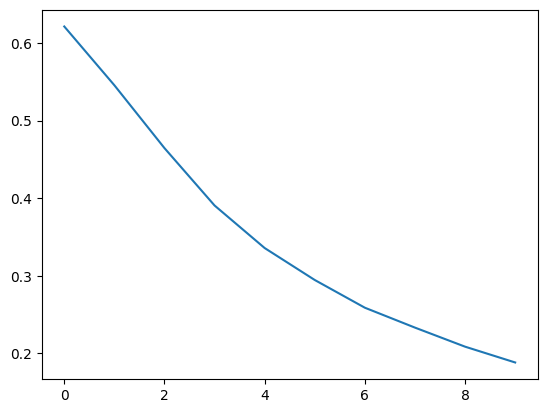

In [381]:
loss_list = [tensor.item() for tensor in loss_list]
plt.plot(loss_list)

In [375]:
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val.values)
X_val = X_val.to(dtype = torch.float32)
Y_val = Y_val.to(dtype = torch.float32)
Y_val = Y_val.reshape(179 ,1)

In [387]:
#model eval
model.eval()
with torch.no_grad():
    val_pred = model(X_val)
    loss = loss_fn(val_pred, Y_val)
    print(f"Loss on the cross validation set is: {loss}")


Loss on the cross validation set is: 0.4807772934436798


In [388]:
Y_test = model(X_test).round()
Y_test = Y_test.to(dtype = torch.int32)
Y_test = Y_test.detach().numpy()


In [389]:
test_df['Survived'] = Y_test


In [390]:
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,1,34.50000,0,0,7.8292,3,0
1,893,3,0,47.00000,1,0,7.0000,1,0
2,894,2,1,62.00000,0,0,9.6875,3,0
3,895,3,1,27.00000,0,0,8.6625,1,0
4,896,3,0,22.00000,1,1,12.2875,1,0
...,...,...,...,...,...,...,...,...,...
413,1305,3,1,30.27259,0,0,8.0500,1,0
414,1306,1,0,39.00000,0,0,108.9000,2,1
415,1307,3,1,38.50000,0,0,7.2500,1,0
416,1308,3,1,30.27259,0,0,8.0500,1,0


In [391]:
test_df[['PassengerId', 'Survived']].to_csv('titanic_pred.csv', index = False)